In [1]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from konlpy.tag import Hannanum
from konlpy.tag import Komoran
from hanspell import spell_checker
import re
from konlpy.tag import Okt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from konlpy.tag import Kkma
from sklearn.linear_model import Lasso
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import tensorflow as tf
import os
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve
#from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score
from soynlp.normalizer import *
from soynlp.utils import DoublespaceLineCorpus
from soynlp.noun import LRNounExtractor_v2

In [2]:
df = pd.read_csv('./result/2021-04-16_구글 마켓컬리.csv')
df1 = pd.read_csv('./result/2021-04-16_마켓컬리.csv')

In [3]:
df.describe()

,ratings,helpful
count,7395.000000,7395.000000
mean,4.368087,1.370521
std,1.230642,8.454966
min,1.000000,0.000000
25%,4.000000,0.000000
50%,5.000000,0.000000
75%,5.000000,0.000000
max,5.000000,283.000000


In [4]:
df = df[['date', 'comment', 'ratings']]
df1 = df1[['date', 'comment', 'ratings']]

In [5]:
df = df.dropna(axis = 0, how = 'any')
df1 = df1.dropna(axis = 0, how = 'any')
df = pd.concat([df, df1])
df = df.reset_index()
del df['index']

In [6]:
from soyspacing.countbase import CountSpace
def 띄어쓰기(text):
    verbose=False
    mc = 10  # min_count
    ft = 0.3 # force_abs_threshold
    nt =-0.3 # nonspace_threshold
    st = 0.3 # space_threshold


    sent_corrected, tags = model.correct(
    doc=text,
    verbose=verbose,
    force_abs_threshold=ft,
    nonspace_threshold=nt,
    space_threshold=st,
    min_count=mc)
    sent_corrected, tags = model.correct(text)
    result = sent_corrected
    return result
corpus_fname = './result/134963_norm.txt'
model = CountSpace()
model.train(corpus_fname)    

df['comment'] = df['comment'].apply(lambda x: 띄어쓰기(x))
df.head()
    
    

all tags length = 694236 --> 57795, (num_doc = 15602)

,date,comment,ratings
0,2021-04-16,너무편리해요,5
1,2021-04-16,깔끔한 앱,5
2,2021-04-16,가격대별로 볼수 있는 기능있음 좋겠습니다 딱 5000원만 딱3000원 더 골르면 더...,1
3,2021-04-16,빠른배송감사합니다,5
4,2021-04-16,물품다양 고퀄리티 원료굿 배송굿 서비스굿,5


In [7]:
#맞춤법 검사기
for i in tqdm(range(len(df))): 
    try: 
        result = spell_checker.check(df['comment'][i])
        a= result[1]
        df['comment'][i] = a
    except: 
        pass



D:\programfiles\anaconda3\envs\pythonopencv\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [8]:
def text_cleaning(text):
    result = only_hangle(text)
    result = repeat_normalize(result, num_repeats=2) #반복적인 단어 응축(2번 이상인것들)
    result = emoticon_normalize(result,num_repeats=2) #반복적인 자음,모음 응축(2번 이상인것들)
    return result
df['ko_text'] = df['comment'].apply(lambda x: text_cleaning(x))
df.head()

,date,comment,ratings,ko_text
0,2021-04-16,너무편리해요,5,너무편리해요
1,2021-04-16,깔끔한 앱,5,깔끔한 앱
2,2021-04-16,가격대별로 볼수 있는 기능있음 좋겠습니다 딱 5000원만 딱3000원 더 골르면 더...,1,가격대별로 볼수 있는 기능있음 좋겠습니다 딱 원만 딱 원 더 골르면 더있음 쿠폰쓸수...
3,2021-04-16,빠른배송감사합니다,5,빠른배송감사합니다
4,2021-04-16,물품다양 고퀄리티 원료굿 배송굿 서비스굿,5,물품다양 고퀄리티 원료굿 배송굿 서비스굿


In [9]:
from soynlp.word import WordExtractor
from soynlp.utils import DoublespaceLineCorpus
from soynlp.tokenizer import LTokenizer
word_extractor = WordExtractor(min_frequency=100,
   min_cohesion_forward=0.05,
   min_right_branching_entropy=0.0
)
word_extractor.train(df['ko_text'].values)
words = word_extractor.extract()
words

cohesion_score = {word:score.cohesion_forward for word, score in words.items()}
tokenizer = LTokenizer(scores=cohesion_score)


training was done. used memory 0.743 Gb
all cohesion probabilities was computed. # words = 298
all branching entropies was computed # words = 10930
all accessor variety was computed # words = 10930


In [10]:
df['nouns'] = df['ko_text'].apply(lambda x: tokenizer.tokenize(x, remove_r=True)) # L과 R 분리하여 R은 삭제
df

,date,comment,ratings,ko_text,nouns
0,2021-04-16,너무편리해요,5,너무편리해요,[너무]
1,2021-04-16,깔끔한 앱,5,깔끔한 앱,"[깔끔, 앱]"
2,2021-04-16,가격대별로 볼수 있는 기능있음 좋겠습니다 딱 5000원만 딱3000원 더 골르면 더...,1,가격대별로 볼수 있는 기능있음 좋겠습니다 딱 원만 딱 원 더 골르면 더있음 쿠폰쓸수...,"[가격, 볼수, 있는, 기능, 좋겠, 딱, 원만, 딱, 원, 더, 골르면, 더있음,..."
3,2021-04-16,빠른배송감사합니다,5,빠른배송감사합니다,[빠른배송]
4,2021-04-16,물품다양 고퀄리티 원료굿 배송굿 서비스굿,5,물품다양 고퀄리티 원료굿 배송굿 서비스굿,"[물품다양, 고퀄리티, 원료굿, 배송, 서비스]"
...,...,...,...,...,...
10385,2016-03-02,매일 출근하면 컬리 사이트 보는게 일과였던 요즘~~ㅎㅎ 앱 출시로 더 가까이 접하게...,5,매일 출근하면 컬리 사이트 보는게 일과였던 요즘 ㅎㅎ 앱 출시로 더 가까이 접하게 ...,"[매일, 출근하면, 컬리, 사이트, 보는게, 일과였던, 요즘, ㅎㅎ, 앱, 출시로,..."
10386,2016-03-02,"시행착오가 있을듯은 하나,",1,시행착오가 있을듯은 하나,"[시행착오가, 있을듯은, 하나]"
10387,2016-03-02,드뎌 컬리앱이 나왔네요,5,드뎌 컬리앱이 나왔네요,"[드뎌, 컬리, 나왔네요]"
10388,2016-03-02,처음 런칭했을 때가 신혼 초였는데요. 7개월 된 아기 엄마가 된 지금까지 참새 방앗...,5,처음 런칭했을 때가 신혼 초였는데요 개월 된 아기 엄마가 된 지금까지 참새 방앗간처...,"[처음, 런칭했을, 때가, 신혼, 초였는데요, 개월, 된, 아기, 엄마가, 된, 지..."


In [11]:
df.describe()

,ratings
count,10390.000000
mean,4.352936
std,1.237850
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [12]:
df = df.reset_index()
del df['index']

In [13]:
# 한국어 약식 불용어사전 예시 파일 출처 - (https://www.ranks.nl/stopwords/korean)
korean_stopwords_path = "./korean_stopwords222.txt"
with open(korean_stopwords_path, encoding='utf8') as f:
    stopwords = f.readlines()
stopwords = [x.strip() for x in stopwords]

def get_nouns(x):
    nouns_tagger = tokenizer
    nouns = nouns_tagger.tokenize(x, remove_r=True)
    nouns = ','.join(nouns)
    nouns_tagger2 =  Okt()
    nouns = nouns_tagger2.nouns(x)
    
    # 한글자 키워드를 제거합니다.
    nouns = [noun for noun in nouns if len(noun) > 1]
    
    # 불용어를 제거합니다.
    nouns = [noun for noun in nouns if noun not in stopwords]
    
    return nouns

In [14]:
df['nouns'] = df['ko_text'].apply(lambda x: get_nouns(x))
for i in tqdm(range(len(df))):
    if not df['nouns'][i]:
        df.drop([i],inplace=True)
        
df.reset_index(inplace=True)
del df['index']
print(df.shape)
df.head()


(6275, 5)


,date,comment,ratings,ko_text,nouns
0,2021-04-16,가격대별로 볼수 있는 기능있음 좋겠습니다 딱 5000원만 딱3000원 더 골르면 더...,1,가격대별로 볼수 있는 기능있음 좋겠습니다 딱 원만 딱 원 더 골르면 더있음 쿠폰쓸수...,"[가격, 대별, 기능, 원만, 쿠폰]"
1,2021-04-16,물품다양 고퀄리티 원료굿 배송굿 서비스굿,5,물품다양 고퀄리티 원료굿 배송굿 서비스굿,"[물품, 다양, 퀄리티, 원료, 서비스]"
2,2021-04-16,추 .ㅊ. ㅓ.ㅇ .ㅣ : ( 222444 ) 진짜 좋아요.~~^^ 잘 사용.하고 ...,5,추 ㅊ ㅓ ㅇ ㅣ 진짜 좋아요 잘 사용 하고 있습니다 실은 전에 쿠팡 로켓프 레쉬를...,"[진짜, 쿠팡, 로켓, 레쉬, 박스, 어서, 회원, 탈퇴, 사이, 소량, 구매, 관..."
3,2021-04-15,다 좋은데 후기 수정할 수 있으면 좋겠어요,4,다 좋은데 후기 수정할 수 있으면 좋겠어요,"[후기, 수정]"
4,2021-04-15,가입은 진즉에 했는데 첫주문을 뒤늦게 하면서 왜 이제서야 주문을 했는지 후회막심입니...,5,가입은 진즉에 했는데 첫주문을 뒤늦게 하면서 왜 이제서야 주문을 했는지 후회막심입니...,"[가입, 진즉, 주문, 주문, 후회, 막심, 주문, 실패, 이지, 장바구니, 모바일..."


In [15]:
all_words = []
satisfaction= []
for i in range(len(df)):
    words = df['nouns'][i]
    words_arr = []
    for n in words:
        words_arr.append(n)
        satisfaction.append(df['ratings'].iloc[i])
    all_words.extend(words_arr)
    
all_words_df = pd.DataFrame({"words":all_words, "satisfaction":satisfaction, "count":len(all_words)*[1]})
all_words_df.head()        
    

,words,satisfaction,count
0,가격,1,1
1,대별,1,1
2,기능,1,1
3,원만,1,1
4,쿠폰,1,1


In [16]:
words_satisfaction = all_words_df.groupby('words').mean()['satisfaction']
words_count = all_words_df.groupby('words').sum()['count']
words_df = pd.concat([words_satisfaction, words_count], axis=1)
words_df.head(20)

,satisfaction,count
words,,
가가,3.000000,2
가감,5.000000,1
가게,3.875000,8
가격,4.116809,351
가계,1.000000,1
가공,4.000000,6
가관,1.000000,1
가구,4.437500,16
가구라,5.000000,2


In [17]:
words_df = words_df.loc[words_df['count']>=3]
words_df.sort_values('satisfaction', ascending=False)

,satisfaction,count
words,,
성품,5.0,3
국산,5.0,3
일어나서,5.0,6
퇴근길,5.0,3
리해,5.0,3
...,...,...
보상,1.0,3
안함,1.0,3
날림,1.0,3


In [18]:
words_df.sort_values('count', ascending =False).head(20)

,satisfaction,count
words,,
주문,3.655251,876
포장,4.501931,518
구매,3.984375,512
쿠폰,4.053398,412
가격,4.116809,351
결제,2.965079,315
가입,2.138790,281
어플,3.330739,257
기능,3.898039,255


In [19]:
korean_stopwords_path = "./korean_stopwords222.txt"
with open(korean_stopwords_path, encoding='utf8') as f:
    stopwords = f.readlines()
stopwords = [x.strip() for x in stopwords]
def text_cleaning(text):
    result = only_hangle(text)
    result = repeat_normalize(result, num_repeats=2) #num_repeats 
    result = emoticon_normalize(result,num_repeats=2 )
    nouns_tagger = tokenizer
    nouns = nouns_tagger.tokenize(result, remove_r=True)
    nouns = ','.join(nouns)
    nouns_tagger2 =  Okt()
    nouns = nouns_tagger2.nouns(nouns)
    nouns = [x for x in nouns if len(x) >1]
    nouns =[x for x in nouns if x not in stopwords]
    return nouns

vect = CountVectorizer(tokenizer= lambda x : text_cleaning(x))
bow_vect = vect.fit_transform(df['comment'].tolist())
word_list = vect.get_feature_names()
count_list = bow_vect.toarray().sum(axis=0)

In [20]:
bow_vect.shape

(6275, 4077)

In [21]:
word_count_dict = dict(zip(word_list, count_list))
print(str(word_count_dict)[:100])

{'가가': 2, '가감': 1, '가게': 8, '가격': 337, '가계': 1, '가공': 6, '가관': 1, '가구': 16, '가구라': 2, '가까이': 6, '가끔'


In [22]:
tfidf_vectorizer = TfidfTransformer()
tf_idf_vect = tfidf_vectorizer.fit_transform(bow_vect)

In [23]:
print(tf_idf_vect[0])

  (0, 3572)	0.3497218130350493
  (0, 2557)	0.7807969670990753
  (0, 445)	0.38661390093912257
  (0, 3)	0.34435510923608736


In [24]:
invert_index_vectorizer = {v:k for k,v in vect.vocabulary_.items()}
print(str(invert_index_vectorizer)[:100])

{3: '가격', 445: '기능', 2557: '원만', 3572: '쿠폰', 1214: '물품', 667: '다양', 3576: '퀄리티', 2556: '원료', 1782: '


In [25]:
df.sample(10).head()

,date,comment,ratings,ko_text,nouns
3600,2019-05-16,신선한 제품을 아침에 배송 받을 수 있다는 사실이 참 획기적이다,5,신선한 제품을 아침에 배송 받을 수 있다는 사실이 참 획기적이다,"[사실, 획기]"
3512,2019-08-21,( 777888 )평균값이 비싼편이지만 품질이 좋고 무엇보다 급하게 쓰고 싶은 식재...,5,평균값이 비싼편이지만 품질이 좋고 무엇보다 급하게 쓰고 싶은 식재료를 아침에 문앞에...,"[평균값, 편이, 품질, 광고, 광고, 회사, 이미지, 위해, 소비, 품질, 서비스..."
5497,2020-06-17,과대포장으로 인한 쓰레기를 줄여주세요~,4,과대포장으로 인한 쓰레기를 줄여주세요,"[과대, 포장, 쓰레기]"
3621,2019-04-16,빠른배송 좋은품질 만족합니다^^,5,빠른배송 좋은품질 만족합니다,[품질]
4734,2020-04-07,요즘 코로나 때문에 온라인 쇼핑 많이 하는데 마켓컬리는 제품이 신선해서 믿고 사는거...,5,요즘 코로나 때문에 온라인 쇼핑 많이 하는데 마켓컬리는 제품이 신선해서 믿고 사는거...,[때문]


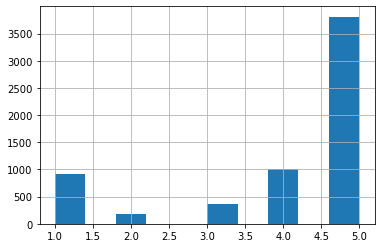

In [26]:
df.ratings.hist()

In [27]:
def rating_to_label(rating) :
  if rating >3:
    return 1
  else:
    return 0
df['y'] = df['ratings'].apply(lambda x : rating_to_label(x))

In [28]:
df

,date,comment,ratings,ko_text,nouns,y
0,2021-04-16,가격대별로 볼수 있는 기능있음 좋겠습니다 딱 5000원만 딱3000원 더 골르면 더...,1,가격대별로 볼수 있는 기능있음 좋겠습니다 딱 원만 딱 원 더 골르면 더있음 쿠폰쓸수...,"[가격, 대별, 기능, 원만, 쿠폰]",0
1,2021-04-16,물품다양 고퀄리티 원료굿 배송굿 서비스굿,5,물품다양 고퀄리티 원료굿 배송굿 서비스굿,"[물품, 다양, 퀄리티, 원료, 서비스]",1
2,2021-04-16,추 .ㅊ. ㅓ.ㅇ .ㅣ : ( 222444 ) 진짜 좋아요.~~^^ 잘 사용.하고 ...,5,추 ㅊ ㅓ ㅇ ㅣ 진짜 좋아요 잘 사용 하고 있습니다 실은 전에 쿠팡 로켓프 레쉬를...,"[진짜, 쿠팡, 로켓, 레쉬, 박스, 어서, 회원, 탈퇴, 사이, 소량, 구매, 관...",1
3,2021-04-15,다 좋은데 후기 수정할 수 있으면 좋겠어요,4,다 좋은데 후기 수정할 수 있으면 좋겠어요,"[후기, 수정]",1
4,2021-04-15,가입은 진즉에 했는데 첫주문을 뒤늦게 하면서 왜 이제서야 주문을 했는지 후회막심입니...,5,가입은 진즉에 했는데 첫주문을 뒤늦게 하면서 왜 이제서야 주문을 했는지 후회막심입니...,"[가입, 진즉, 주문, 주문, 후회, 막심, 주문, 실패, 이지, 장바구니, 모바일...",1
...,...,...,...,...,...,...
6270,2016-03-27,엄선된 제품,5,엄선된 제품,[엄선],1
6271,2016-03-02,매일 출근하면 컬리 사이트 보는게 일과였던 요즘~~ㅎㅎ 앱 출시로 더 가까이 접하게...,5,매일 출근하면 컬리 사이트 보는게 일과였던 요즘 ㅎㅎ 앱 출시로 더 가까이 접하게 ...,"[출근, 사이트, 일과, 가까이, 맞벌이, 신혼부부, 사이트, 신랑, 주문, 널리,...",1
6272,2016-03-02,"시행착오가 있을듯은 하나,",1,시행착오가 있을듯은 하나,[시행착오],0
6273,2016-03-02,드뎌 컬리앱이 나왔네요,5,드뎌 컬리앱이 나왔네요,[드뎌],1


In [29]:
df.y.value_counts()

1    4813
0    1462
Name: y, dtype: int64

In [30]:
y= df['y']
X_train,X_test, y_train, y_test = train_test_split(tf_idf_vect, y, test_size = 0.3, random_state=40)

In [31]:
print(X_test.shape)

(1883, 4077)


# 로지스틱 회귀

In [32]:
#불용어 배송 아래부터 바꾸면 됨 배송이란 단어를 남기고싶으면
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver="lbfgs", max_iter=500)
lr.fit(X_train, y_train)
print("Test Accuracy: {}%".format(round(lr.score(X_test, y_test)*100,2)))

Test Accuracy: 82.37%


In [33]:
scores = cross_val_score(lr, tf_idf_vect, y, cv=10) # model, train, target, cross validation

print('cross-val-score \n{}'.format(scores))

print('cross-val-score.mean \n{:.3f}'.format(scores.mean()))

cross-val-score 
[0.83598726 0.83121019 0.84713376 0.83280255 0.84872611 0.82934609
 0.8277512  0.8261563  0.81499203 0.79585327]
cross-val-score.mean 
0.829


In [34]:
y_pred_lr = lr.predict(X_test)
print("Logistic Regression Classifier report: \n\n", classification_report(y_test, y_pred_lr))

Logistic Regression Classifier report: 

               precision    recall  f1-score   support

           0       0.83      0.34      0.48       455
           1       0.82      0.98      0.89      1428

    accuracy                           0.82      1883
   macro avg       0.83      0.66      0.69      1883
weighted avg       0.82      0.82      0.79      1883



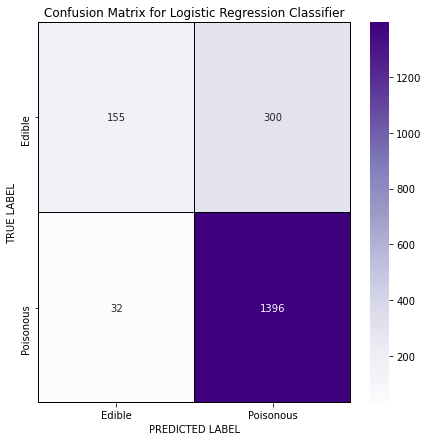

In [35]:
cm = confusion_matrix(y_test, y_pred_lr)
x_axis_labels = ["Edible", "Poisonous"]
y_axis_labels = ["Edible", "Poisonous"]
f, ax = plt.subplots(figsize =(7,7))
sns.heatmap(cm, annot = True, linewidths=0.2, linecolor="black", fmt = ".0f", ax=ax, cmap="Purples", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel("PREDICTED LABEL")
plt.ylabel("TRUE LABEL")
plt.title('Confusion Matrix for Logistic Regression Classifier')
#plt.savefig("lrcm.png", format='png', dpi=500, bbox_inches='tight')
plt.show()

In [36]:
# plt.rcParams['figure.figsize'] = [10,8]
# plt.bar(range(len(lr.coef_[0])), lr.coef_[0])

In [37]:
coef_pos_index = sorted(((value, index ) for index, value in enumerate(lr.coef_[0])), reverse=True)
coef_neg_index = sorted(((value,index) for index, value in enumerate(lr.coef_[0])), reverse= False)

In [38]:
i =0
sd  = pd.DataFrame(index=range(0,15), columns=['단어', '오즈비'])
for coef in coef_pos_index[:15]:
  print(invert_index_vectorizer[coef[1]],coef[0]) #띄어쓰기 ,soynlp konlpy  한국어 
  sd.loc[i] = [invert_index_vectorizer[coef[1]],round(coef[0],2) ]
  i = i+1

편리 2.6499790587672765
신선 2.607428335180727
품질 2.0750283348275764
포장 1.5628202409115932
할인 1.4608787982393308
혜택 1.2931320653591425
친환경 1.2675008731830706
간편 1.2016363355003488
질도 1.0380396004540897
다양 1.0166822352726004
가격 1.0116688083660046
퀄리티 0.9937697426405396
소량 0.9533395014293631
저렴 0.9345738089826422
쿠폰 0.8957053571915568


In [39]:
sd['오즈비'] = sd['오즈비'].apply(lambda x : np.exp(x))
sd

,단어,오즈비
0,편리,14.154039
1,신선,13.599051
2,품질,8.004469
3,포장,4.758821
4,할인,4.305960
5,혜택,3.632787
6,친환경,3.560853
7,간편,3.320117
8,질도,2.829217
9,다양,2.773195


In [40]:
for coef in coef_neg_index[:100]:
  print(invert_index_vectorizer[coef[1]], coef[0])

최악 -2.9041559740616485
그냥 -2.9012168511928853
가입 -2.695952218485683
광고 -2.602991099597827
블랙리스트 -2.5681744249533653
설치 -2.564919125156253
오류 -2.4756330730667444
문의 -2.458527990216596
회원 -2.368052807960024
로그인 -2.342846333235934
삭제 -2.1986639175673273
페이지 -2.1143693132469132
탈퇴 -2.0009834225744827
제대로 -1.9532702787203284
엉망 -1.9097924492587743
인증 -1.9075501706742484
업데이트 -1.9037318035614414
이유 -1.8991124246006306
환불 -1.875668834579464
지역 -1.8587133322455263
먹통 -1.8391898349204492
별로 -1.8123808793093288
문제 -1.8077429599468746
제주도 -1.7655734816525812
다시 -1.7619510349737413
이건 -1.7101968234534894
사라 -1.6725127397911284
며칠 -1.6027480188239234
연결 -1.6025558359424699
노트 -1.5945869508227857
카톡 -1.5765881831728694
결제 -1.5664297447178215
자꾸 -1.5503998670822983
전화 -1.5447138196936994
네트워크 -1.5119791482587606
실망 -1.448358783662035
고객 -1.4130320213206713
절대 -1.3995155660236338
마감 -1.3995097910785392
해도 -1.3927564583194312
막상 -1.3841116244012808
초심 -1.377644759009913
다운 -1.377049089632892
실행 -1.3450